In [1]:
import warnings
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import lime
import lime.lime_tabular
import shap

from pipelines.functions import see_results, evaluate_metrics
from ml_injection_pipeline import prediction_pipeline
from tools.feed import data_info
from utils.config import DATASET_PATH, MODELS_PATH, MODEL_DATA_PATH

warnings.filterwarnings("ignore")

# FIRST FINANCIAL ADJUSTMENT TESTING

In [2]:
import pandas as pd

from ml_injection_pipeline import prediction_pipeline
from pipelines.estimators import RemoveOutliers
from utils.config import DATASET_PATH

df = pd.read_csv(DATASET_PATH)
df = RemoveOutliers().fit_transform(df)

df.shape

(4990, 10)

In [3]:
prediction_pipeline(df.drop(columns='price'))

array([4656.5, 6522.4, 5212.9, ..., 1686.6, 1463.7, 1217.3])

In [4]:
prediction_pipeline(df.drop(columns='price').to_dict())

array([4656.5, 6522.4, 5212.9, ..., 1686.6, 1463.7, 1217.3])

In [3]:
import numpy as np
import datetime as dt
avg_infl_rate = 0.04
delta_year = dt.datetime.now().year - 2008
cat_threshold = df.price.median()

# split df in two samples divided by median
exclusive_sample = df.loc[np.where(df.price > cat_threshold)[0], :]
common_sample = df.loc[np.where(df.price <= cat_threshold)[0], :]

# sum the total price of each sample
exclusive_total_price = exclusive_sample.price.sum()
common_total_price = common_sample.price.sum()

# apply a anual inflation rate using (1 + avg_infl_rate) ** delta_year
exclusive_total_price = exclusive_total_price * (1 + avg_infl_rate) ** delta_year
common_total_price = common_total_price * (1 + avg_infl_rate) ** delta_year

exclusive_total_price, common_total_price, exclusive_total_price + common_total_price

(31547992.271073744, 5214334.836554608, 36762327.10762835)

In [16]:
print('Exclusive sample')
preds = prediction_pipeline(exclusive_sample.drop(columns='price'))#.to_dict())
print('# Adjusted by inflation')
print(exclusive_total_price - preds.sum())
print('# real price')
print(exclusive_sample.price.sum() - preds.sum())
exclusive_sample.price.sum(),\
preds.sum()

Exclusive sample
# Adjusted by inflation
14385087.171073742
# real price
-319174.1000000015


(16843731, 17162905.1)

In [5]:
print('Common sample')
preds = prediction_pipeline(common_sample.drop(columns='price'))
print('# Adjusted by inflation')
print(common_total_price - preds.sum())
print('# real price')
print(common_sample.price.sum() - preds.sum())
common_sample.price.sum(), \
preds.sum()

Common sample
# Adjusted by inflation
-2488.3634453918785
# real price
-2432847.2


(2783976, 5216823.2)

In [ ]:
df.price.sum(), prediction_pipeline(df.drop(columns='price')).sum()


abs(df.price.sum() - prediction_pipeline(df.drop(columns='price')).sum()) / df.price.sum() * 100

32.552896780046716

In [ ]:
# print("""# difference between the prediction and the real price
# preds.sum() - y.to_numpy().sum()

# # difference between the real price adjusted by inflation and the prediction
# 36728549.76384291 - preds.sum()""") <--- this number depend on the inflation rate


(16387032.200000003, 731844.5638429075)

# FIRST FINANCIAL ADJUSTMENT CREATION

In [ ]:
X = df.drop(columns='price')
y = df.price

preds = prediction_pipeline(X)

preds

7836.7

In [ ]:
from ml_injection_pipeline import data_transformation

data = data_transformation(X)

if len(data) == 1:
    cat = log_reg.predict(data)[0]
    if cat == 1:
        cat = 'Exclusive'
        pred = lgbm_exclusive.predict(data)[0]
    else:
        cat = 'Common'
        pred = lgbm_common.predict(data)[0]
else:
    cat = log_reg.predict(data)
    cat2 = np.where(cat == 1, 'Exclusive', 'Common')
    pred = np.where(cat == 'Exclusive', lgbm_exclusive.predict(data), lgbm_common.predict(data))
cat

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
y.to_numpy().sum()

19609673

In [ ]:
pred.round(1)

array([ 7836.7, 10190.3,  8095.6, ...,  9182. ,   551.1,   531.9])

In [ ]:
import datetime as dt

delta_year = dt.datetime.now().year - 2008
avg_infl_rate = 0.04
price = 19609673 # output: # 36728549.76384291
price = 19
price * (1 + avg_infl_rate) ** delta_year

36728549.76384291

In [ ]:
print("""# difference between the prediction and the real price
pred.sum() - y.to_numpy().sum()

# difference between the real price adjusted by inflation and the prediction
36728549.76384291 - pred.sum()""")


pred.sum() - y.to_numpy().sum(),\
36728549.76384291 - pred.sum()

# difference between the prediction and the real price
pred.sum() - y.to_numpy().sum()

# difference between the real price adjusted by inflation and the prediction
36728549.76384291 - pred.sum()


(6623252.420022126, 10495624.343820784)

# Challenge 2: Automated pipeline

The **training pipeline** is design as a Python script that when executed, it will read the current `diamond.csv` file stored in the `.dataset/diamond` folder.
Inside the script, there is a **feature engineering** pipeline called `workflow_1` and three other pipelines for the models: `pipeline_1`, `pipeline_2`, and `pipeline_3`.

The intention is to automate the process of training and updating the models with the new data.
One possible way of making the updates automatic is to create a **Apache-Airflow** DAG for scheduling the pipeline execution.

At the moment the pipeline is executed during the container start, but if you want to run it manually these are the necessary steps to follow:

## Pipeline Local Execution

1. Create a virtual environment and install the requirements:

Linux:

```bash
$ python3 -m venv .venv
$ source .venv/bin/activate
$ pip install -r requirements.txt
```

Windows:

```bash
python -m venv .venv
.venv\Scripts\activate
pip install -r requirements.txt
```

<br />

2. Run the pipeline:
```bash
$ python ml_train_pipeline.py
```

After running the script, the models will be saved in the `models` folder and the data in the `models/data` folder.


# Challenge 3: Rest API

In [ ]:
# 1. User Friendly: 
# Creating a home page with information
# Giving access to the parameters explanation
# Creating a form for prediction with choices to the user.

# 2. Importar el modelo: hacer la prediccion, formatear el resultado, y presentarlo en la response.

# 3. Crear POSTMAN collection para probar la API.

import requests

In [ ]:
error

In [ ]:
exit()

# Challenge 4: Architecture explanation

The next step is exposing the model to other businesses, but this calls for an upgrade in the training and serving infrastructure. Using your favorite cloud provider, either AWS, GCP, or Azure, design cloud-based training and serving pipelines. You should not implement the solution, but you should provide a detailed explanation of the architecture and the services you would use, motivating your choices.

# Cementery

In [ ]:
# LIME
# PREDICTIONS EXPLANATION FOR COMMON MODEL
# https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular

X_train = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_train.csv'))

explainer = lime.lime_tabular.LimeTabularExplainer(
X_train.to_numpy(), feature_names=X_train.columns,
verbose=True, mode='regression')

exp = explainer.explain_instance(np.array([sample_0.values]), prediction_pipeline)
exp.show_in_notebook(show_table=True)
exp.as_list()


TypeError: '<' not supported between instances of 'float' and 'str'

: 

![lime output](static/img/lime_output.png)

In [ ]:
# SHAP
# EXPLANATION VIA SHAP
explainer = shap.Explainer(prediction_pipeline)

print("real price:", real_0)
print("prediction:", pred_0)

shap_values = explainer(sample_0.values)
shap.plots.waterfall(shap_values[0])

ValueError: masker cannot be None.

real price: [17317]
prediction: [14864.2]


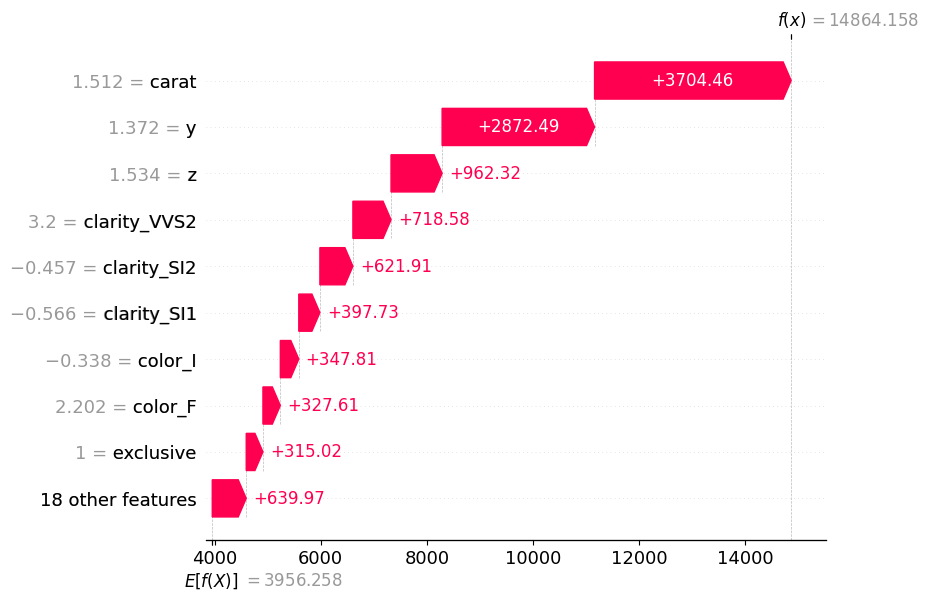

In [ ]:
# SHAP
# EXPLANATION VIA SHAP
explainer = shap.Explainer(lgbm)
print("real price:", y_test.iloc[predict_index].values)
print("prediction:", lgbm.predict(X_test.iloc[predict_index]).round(1))
shap_values = explainer(X_test.iloc[predict_index].to_frame().T)
shap.plots.waterfall(shap_values[0])